# Set up functions to compute sparese regression and DMD

Define a wrapper for scikit learn's lasso function

In [62]:
def lasso(A,b,alpha=1):
    '''
    Parameters
    ----------
    A: array like 
    b: array like (must be compatiable with A)
    alpha: float
    Returns
    -------
    array solving minimization problem: min_x: ||b-Ax||_2 + alpha*||x||_1
    '''
    reg = linear_model.Lasso(alpha=alpha/len(A))
    reg.fit(A,b)
    return reg.coef_

In [63]:
def get_poly_exponents(l, n, start=0):
    '''
    Parameters
    ----------
    l: integer
    n: integer
    start: integer

    Returns
    -------
    generator of all tuples of length l whose minimum entry is start and whose entries sum to at most n
    '''
    if l == 0:
        yield ()
    else:
        for x in range(start, n+1):
            for t in get_poly_exponents(l - 1, n):
                if sum(t) + x <= n:
                    yield t + (x,)

In [64]:
def binomial_expand(x,d):
    '''
    Parameters
    ----------
    x: array like 
    max_deg: integer

    Returns
    -------
    ndarray whose entries are 1, x_0, x_1, ..., x_k, x_0^2, x_0x_1, ..., x_0x_k, x_1^2, x_1x_2, ...
    '''
    E_ = np.array(list(get_poly_exponents(len(x),d)))
    E = E_[np.argsort(np.sum(E_,axis=1))]
    return np.array([np.prod([x[k]**e[k] for k in range(len(x))],axis=0) for e in E ]).T

def print_binomial_expand(x,d):
    E_ = np.array(list(get_poly_exponents(len(x),d)))
    E = E_[np.argsort(np.sum(E_,axis=1))]
    for j,e in enumerate(E):
        print('coefficient:',j,'--> exponents:',e)

In [65]:
def time_delay_embed(x,J):
    '''
    Compute time delay embedding matrix of x
    '''
    return np.reshape([x[:,j:-J+j] for j in range(J)],(-1,np.shape(x)[1]-J))

In [66]:
def get_dmd_modes(X1,X2,r):
    '''
    Compute approximate eigenvetors and values to A solving min |X2-AX1|_F
    '''
    u,s,vt = np.linalg.svd(X1,full_matrices=False)

    u_hat = u[:,:r]
    s_hat = s[:r]
    v_hat = vt[:r].conjugate().T

    S = u_hat.conjugate().T@X2@v_hat@np.diag(1/s_hat)
    
    Lambda,W = np.linalg.eig(S)
    
    Phi = X2@v_hat@np.diag(1/s_hat)@W#@np.diag(Lambda)
    
    return Lambda, Phi
    
def get_mode_time_evolution(Lambda, Phi, x0, t):
    '''
    Compute weighting of DMD in time
    '''
    dt = t[1]-t[0]
    
    omega = np.log(Lambda)/dt
    b = np.linalg.lstsq(Phi,x0)[0]
    
    def u_modes(t): 
        return np.exp(omega*t)*b
    
    return np.array([u_modes(tj) for tj in t]).T

# Generate Data

Generate solution on mesh up to time $ t=50 $ for dynamical system,
$$ \left[\begin{array}{c} \dot{x_1} \\ \dot{x_2} \end{array}\right] 
=
\left[\begin{array}{c} x_2 \\ \mu(1-x_1^2)x_2-x_1 \end{array}\right] 
$$ 

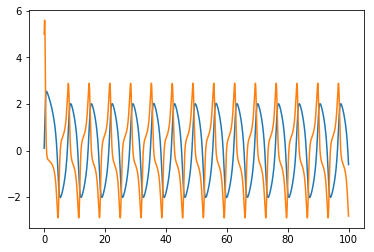

In [67]:
dt = 0.01
T = 100
t = np.arange(0,T+dt,dt)

y0 = np.array([0.1,5])
mu = 1.2

# generate solution on mesh
sol = sp.integrate.solve_ivp(lambda t,x: np.array([x[1], mu*(1-x[0]**2)*x[1]-x[0]]),[0,T],y0,t_eval=t)

x = sol.y

# add some noise for testing
#x += 0.05*np.random.randn(2,len(t))

plt.figure()
plt.plot(t,x[0])
plt.plot(t,x[1])
plt.show()

# 1. Use sparse regression techniques to identify the nonlinear dynamical system that produced the data.

coefficient: 0 --> exponents: [0 0]
coefficient: 1 --> exponents: [1 0]
coefficient: 2 --> exponents: [0 1]
coefficient: 3 --> exponents: [2 0]
coefficient: 4 --> exponents: [1 1]
coefficient: 5 --> exponents: [0 2]
coefficient: 6 --> exponents: [3 0]
coefficient: 7 --> exponents: [2 1]
coefficient: 8 --> exponents: [1 2]
coefficient: 9 --> exponents: [0 3]


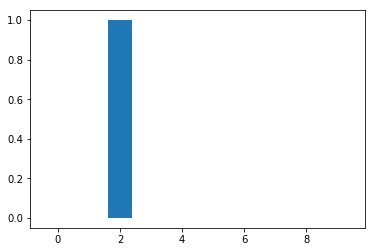

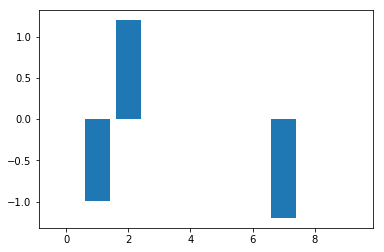

In [68]:
# take mesh points up to t=40
N = int(40/dt)
x0 = x[0,:N]
x1 = x[1,:N]

# print order of terms in library
print_binomial_expand([x0,x1],3)

# generate library
lib = binomial_expand([x0,x1],3)

# compute time derivative of x
x_t = (x[:,2:N]-x[:,:N-2])/(2*dt)

# do sparse regression
c = lasso(lib[1:-1],x_t.T,1)


# plot coefficeints
plt.figure()
plt.bar(np.arange(len(c.T)),c[0])
plt.show()

plt.figure()
plt.bar(np.arange(len(c.T)),c[1])
plt.show()

### Remove columns of library with small coefficients and re-regress

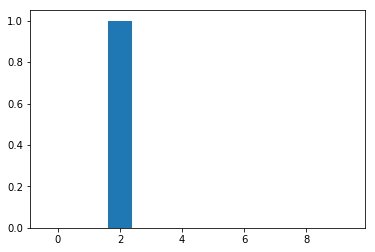

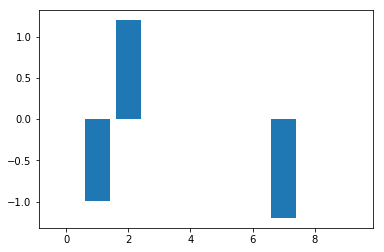

In [69]:
tol = 1e-1

d = np.zeros(np.shape(c))

d[0,:] = np.linalg.lstsq(lib[1:-1]@np.diag(np.abs(c[0])>tol),x_t[0].T)[0]
d[1,:] = np.linalg.lstsq(lib[1:-1]@np.diag(np.abs(c[1])>tol),x_t[1].T)[0]

# plot coefficeints
plt.figure()
plt.bar(np.arange(len(d.T)),d[0])
plt.show()

plt.figure()
plt.bar(np.arange(len(d.T)),d[1])
plt.show()

# 2. With your discovered dynamical system, evaluate its ability to forecast by matching your predictions with the second downloaded data set. Use the first row of the data matrix to extract your initial conditions and measure the error in your trajectory to the true trajectory

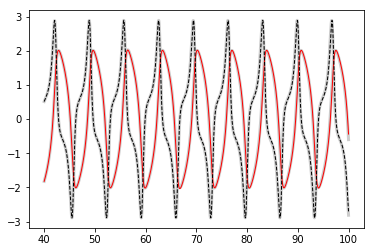

In [70]:
y0_recovered = x[:,N]
sol_recovered = sp.integrate.solve_ivp(lambda t,x: d@binomial_expand([x[0],x[1]],3),[t[N],T],y0_recovered,t_eval=t[N:])
x_recovered = sol_recovered.y

plt.figure()
plt.plot(t[N:],x[0,N:],c='.8',lw=3)
plt.plot(t[N:],x[1,N:],c='.8',lw=3)
plt.plot(t[N:],x_recovered[0],c='r',ls='-',lw=1)
plt.plot(t[N:],x_recovered[1],c='0',ls='--',lw=1)
plt.show()

# 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [71]:
J=700
H = time_delay_embed(x[:,:N],J)

u,s,vt = np.linalg.svd(H,full_matrices=False)

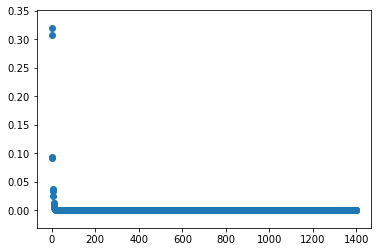

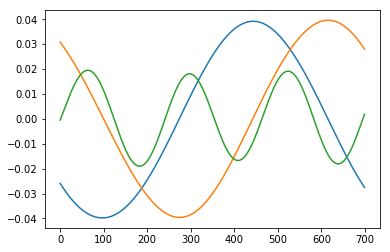

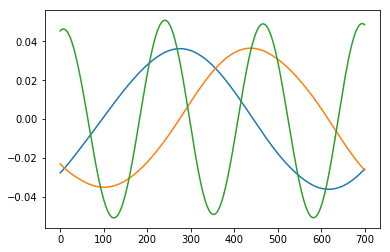

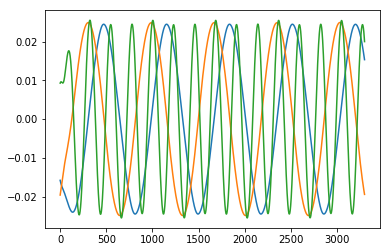

In [72]:
plt.figure()
plt.scatter(np.arange(2*J),s/np.sum(s))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J),u[::2,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J),u[1::2,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(N-J),vt[j])
plt.show()

WHAT FREQUENCIES????????

In [73]:
len(vt[0])
N-J

3300

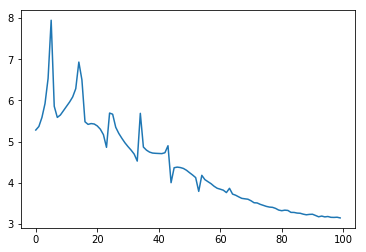

In [74]:
plt.plot(np.arange(100),np.log(np.abs(np.fft.fft(x[1,:N-J]))[:100]))
plt.show()

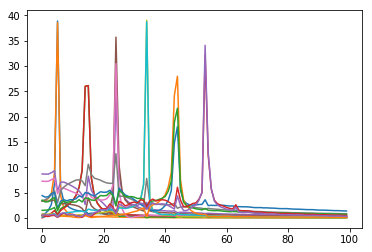

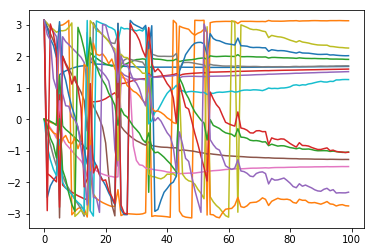

In [75]:
k=100

plt.figure()
for l in range(15):
    plt.plot(np.arange(k),np.abs(np.fft.fft(vt[l]))[:k])
plt.show()

plt.figure()
for l in range(15):
    plt.plot(np.arange(k),np.angle(np.fft.fft(vt[l]))[:k])
plt.show()

# 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the second data set as your test set for this evaluation).

In [76]:
X1_dmd = x[:,:N-J-1]
X2_dmd = x[:,1:N-J]

r_dmd=2
Lambda_dmd,Phi_dmd = get_dmd_modes(X1_dmd,X2_dmd,r_dmd)

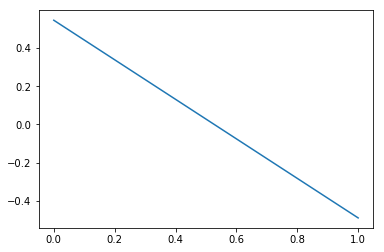

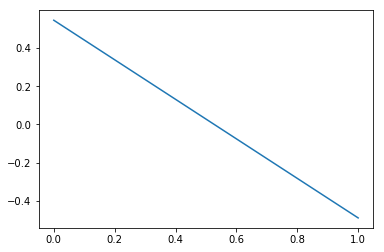

In [77]:
plt.figure()
plt.plot(np.arange(r_dmd),np.real(Phi_dmd[:,0]))
plt.show()

plt.figure()
plt.plot(np.arange(r_dmd),np.real(Phi_dmd[:,1]))
plt.show()

In [78]:
u_modes_dmd = get_mode_time_evolution(Lambda_dmd,Phi_dmd,X1_dmd[:,0],t)


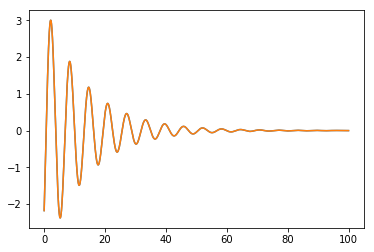

In [79]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd[0]))
plt.plot(t,np.real(u_modes_dmd[1]))
plt.show()

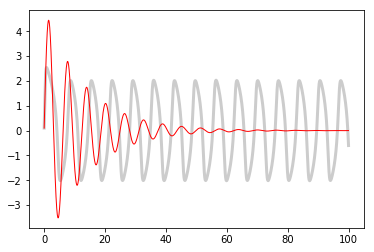

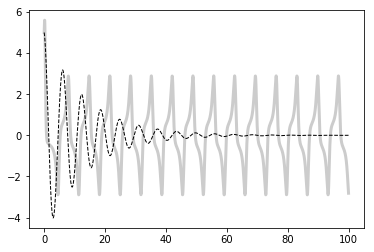

In [80]:
X_dmd = Phi_dmd@u_modes_dmd

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd[0]),c='r',ls='-',lw=1)
plt.show()

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd[1]),c='0',ls='--',lw=1)
plt.show()

# 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [81]:
X1 = H[:,:-1]
X2 = H[:,1:]

r=10
Lambda, Phi = get_dmd_modes(X1,X2,r)

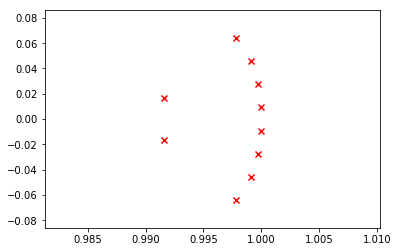

In [82]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda),np.imag(Lambda),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

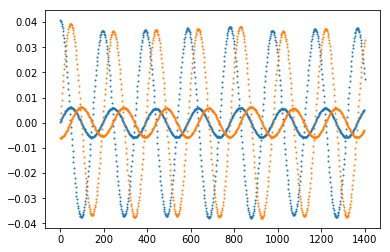

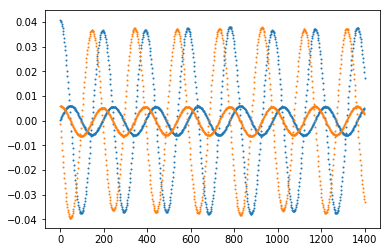

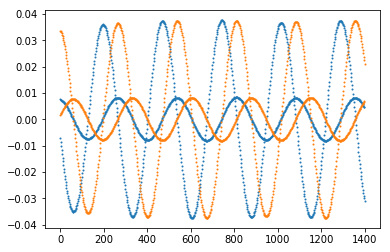

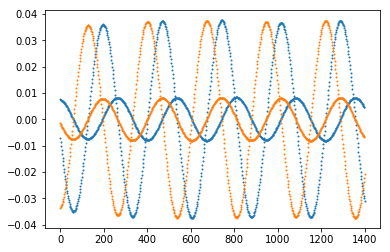

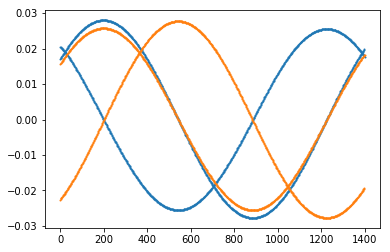

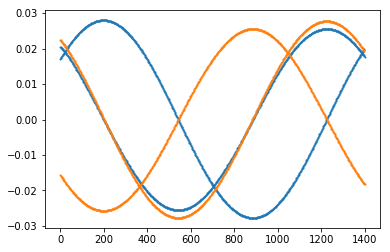

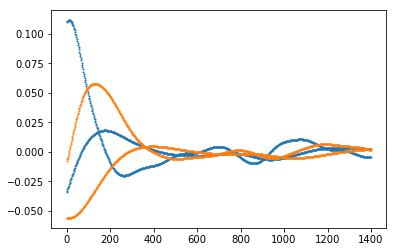

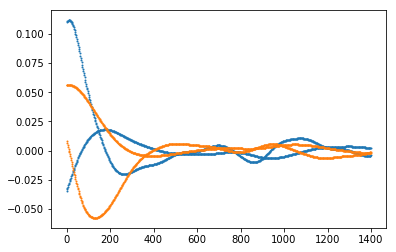

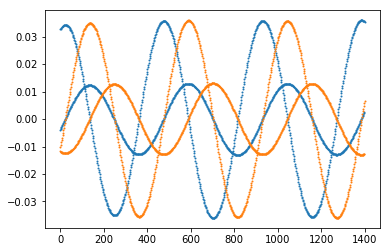

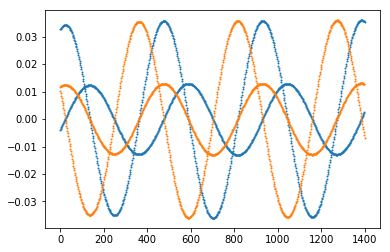

In [83]:
for j in range(r):
    plt.figure()
    plt.plot(np.arange(2*J),np.real(Phi[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(2*J),np.imag(Phi[:,j]),marker='.',ms='2',ls='None')
    plt.show()


In [84]:
u_modes = get_mode_time_evolution(Lambda,Phi,X1[:,0],t)

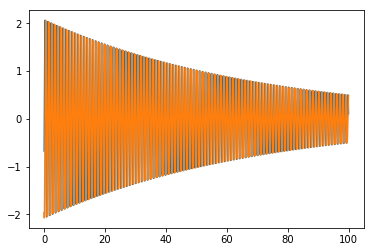

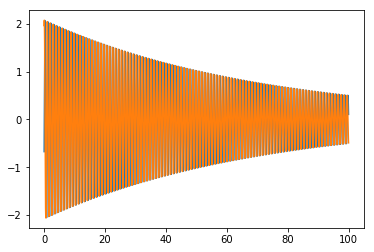

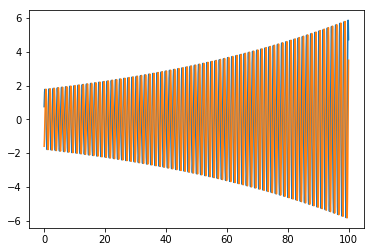

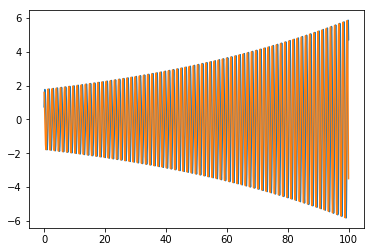

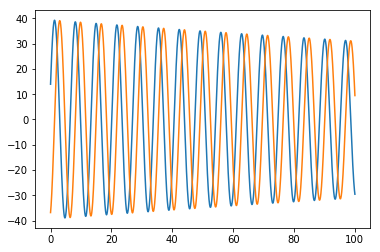

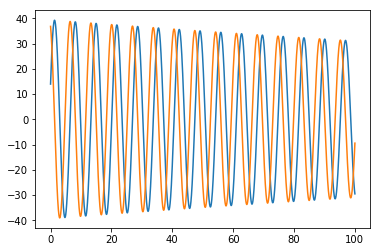

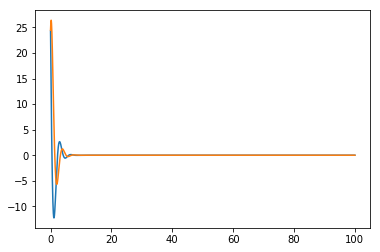

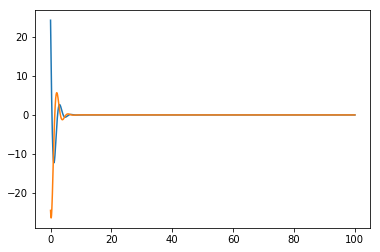

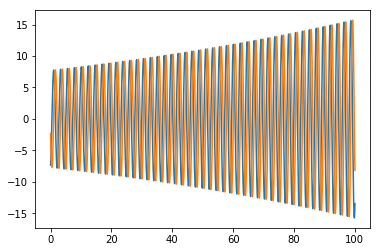

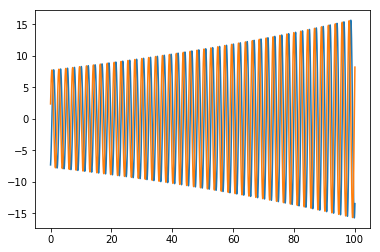

In [85]:
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes[j]))
    plt.plot(t,np.imag(u_modes[j]))
    plt.show()

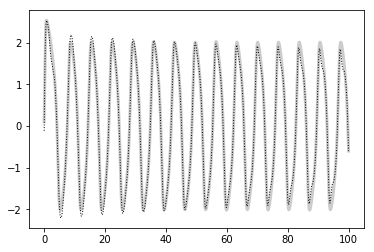

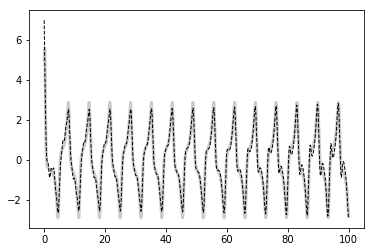

In [86]:
X_dmd_koop = Phi@u_modes

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_koop[0]),c='k',ls=':',lw=1)
plt.show()

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_koop[1]),c='0',ls='--',lw=1)
plt.show()

Try starting from later time (this is a bit weird because you need to regenerate the initial condition for koopman. We use time 40-47 as our new "initial condtion" data

In [102]:
t0 = N+100

x0 = time_delay_embed(x[:,t0:t0+J+1],J)

In [103]:
u_modes = get_mode_time_evolution(Lambda,Phi,x0[:,0],t)

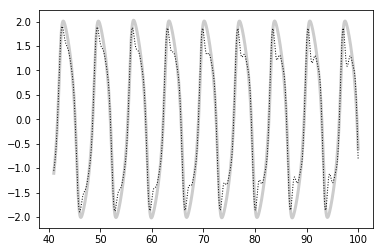

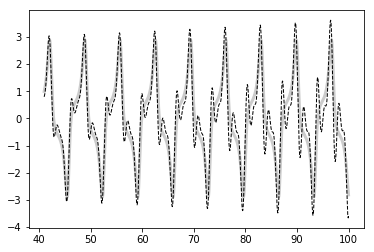

In [104]:
X_dmd_koop = Phi@u_modes

plt.figure()
plt.plot(t[t0:],x[0,t0:],c='.8',linewidth=3)
plt.plot(t[t0:],np.real(X_dmd_koop[0])[t0:],c='k',ls=':',lw=1)
plt.show()

plt.figure()
plt.plot(t[t0:],x[1,t0:],c='.8',linewidth=3)
plt.plot(t[t0:],np.real(X_dmd_koop[1])[t0:],c='0',ls='--',lw=1)
plt.show()

# 6. Using only the $x_1$ data column, repeat the calculations of the previous three bullets.

### 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [24]:
J_0 =700
H_0 = time_delay_embed(np.array([x[0,:N]]),J) # to make shape (1,N) instead of (N,)

u_0,s_0,vt_0 = np.linalg.svd(H_0,full_matrices=False)

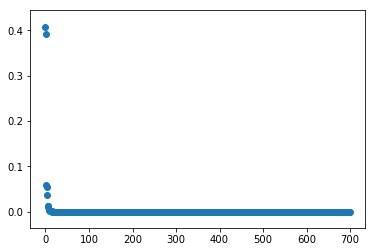

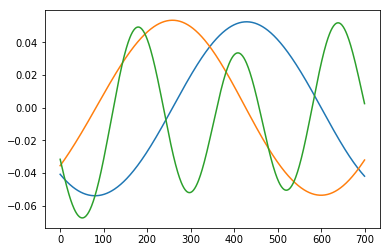

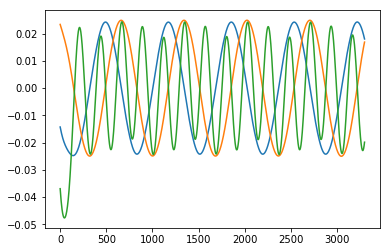

In [25]:
plt.figure()
plt.scatter(np.arange(J_0),s_0/np.sum(s_0))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J_0),u_0[:,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(N-J_0),vt_0[j])
plt.show()

### 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the second data set as your test set for this evaluation).

In [26]:
X1_dmd_0 = np.array([x[0,:N-J-1]])
X2_dmd_0 = np.array([x[0,1:N-J]])

r_dmd_0 = 2
Lambda_dmd_0, Phi_dmd_0 = get_dmd_modes(X1_dmd_0,X2_dmd_0,r_dmd_0)

In [27]:
u_modes_dmd_0 = get_mode_time_evolution(Lambda_dmd_0,Phi_dmd_0,X1_dmd_0[:,0],t)

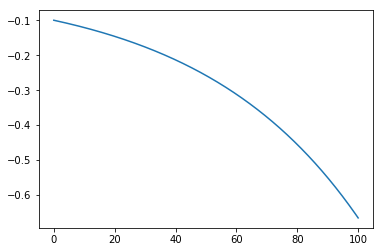

In [28]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd_0[0]))
plt.show()

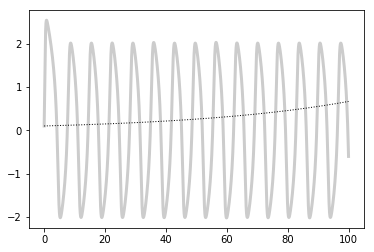

In [29]:
X_dmd_0 = Phi_dmd_0*u_modes_dmd_0

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_0[0]),c='0',ls=':',lw=1)
plt.show()

### 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [30]:
X1_0 = H_0[:,:-1]
X2_0 = H_0[:,1:]

r_0 = 10
Lambda_0, Phi_0 = get_dmd_modes(X1_0,X2_0,r_0)

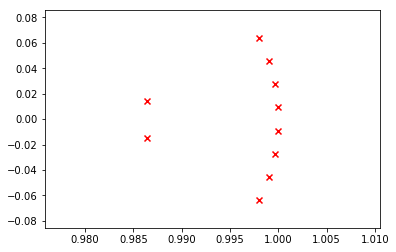

In [31]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda_0),np.imag(Lambda_0),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

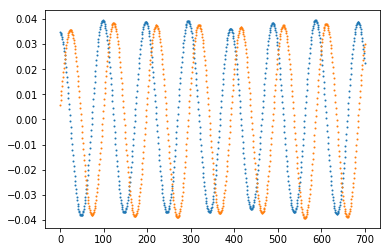

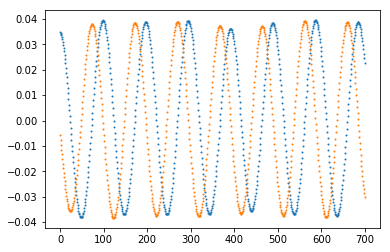

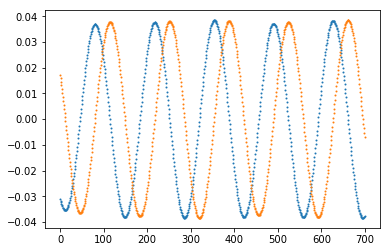

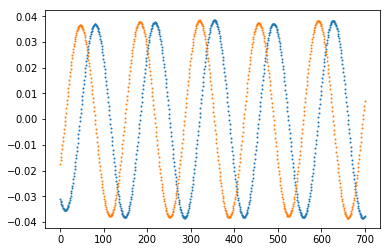

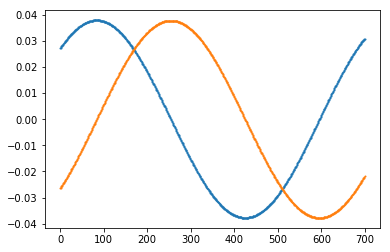

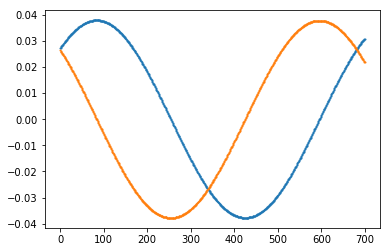

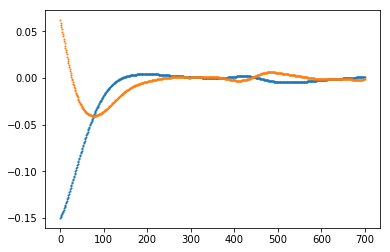

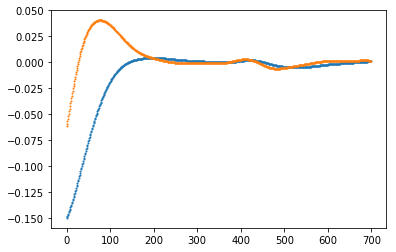

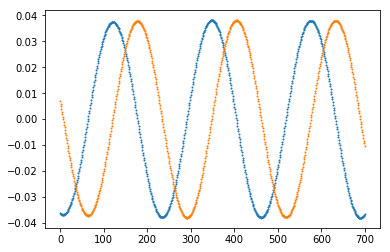

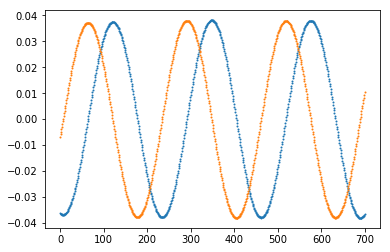

In [32]:
for j in range(r):
    plt.figure()
    plt.plot(np.arange(J_0),np.real(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(J_0),np.imag(Phi_0[:,j]),marker='.',ms='2',ls='None')
    plt.show()

In [33]:
u_modes_0 = get_mode_time_evolution(Lambda_0, Phi_0, X1_0[:,0],t)

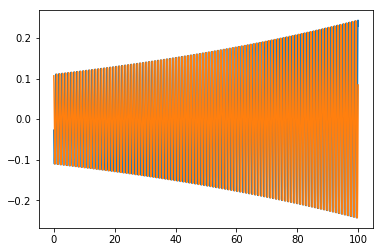

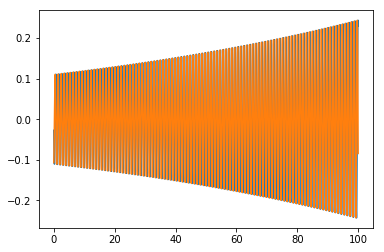

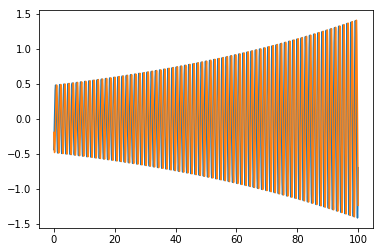

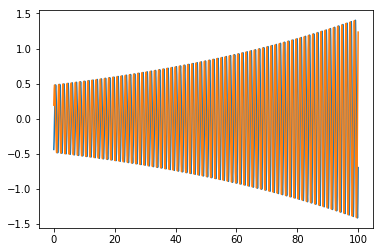

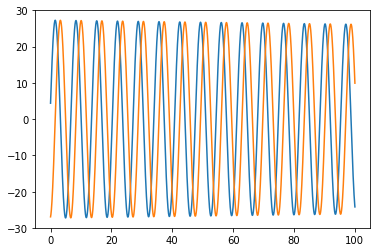

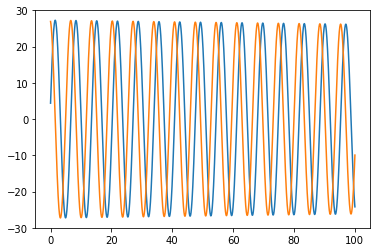

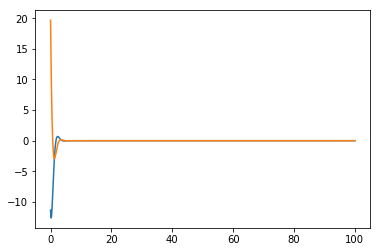

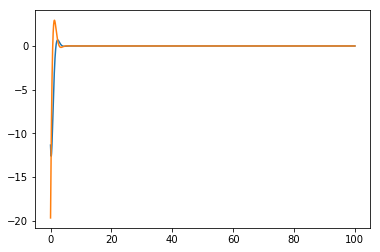

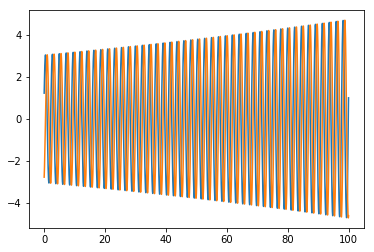

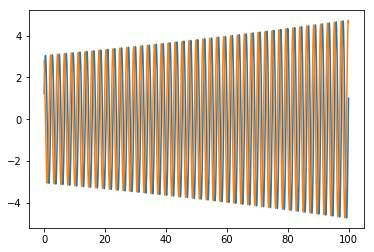

In [34]:
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes_0[j]))
    plt.plot(t,np.imag(u_modes_0[j]))
    plt.show()

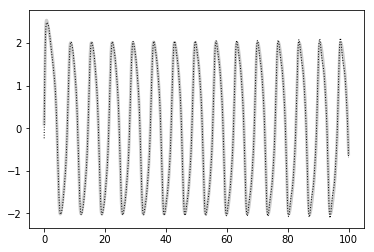

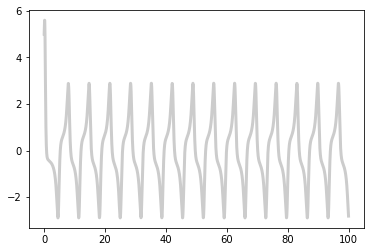

In [35]:
X_dmd_0 = Phi_0@u_modes_0

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_0[0]),c='k',ls=':',lw=1)
plt.show()

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
#plt.plot(t,np.real(X_dmd_0[1]),c='0',ls='--',lw=1)
plt.show()

# 7. Now do this with only $x_2$.

Lol what is the point of doing the same thing again

### 3. Time-delay embed the time series and evaluate the amount of temporal embedding required to linearize the dynamics. How many linear modes and what frequencies are required to characterize the system.

In [36]:
J_1 =700
H_1 = time_delay_embed(np.array([x[1,:N]]),J) # to make shape (1,N) instead of (N,)

u_1,s_1,vt_1 = np.linalg.svd(H_1,full_matrices=False)

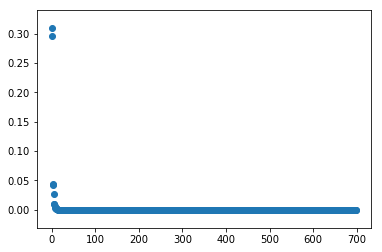

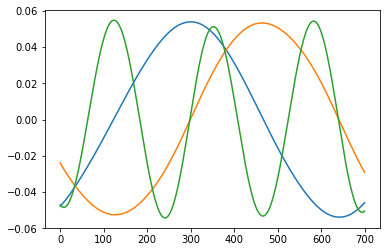

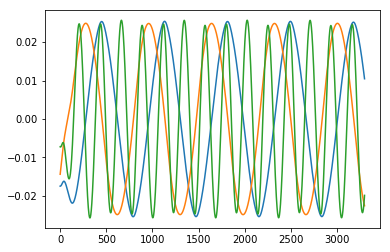

In [37]:
plt.figure()
plt.scatter(np.arange(J_1),s_0/np.sum(s_1))
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(J_1),u_1[:,j])
plt.show()

plt.figure()
for j in range(3):
    plt.plot(np.arange(N-J_1),vt_1[j])
plt.show()

### 4. Use a DMD approximation on the original time series and evaluate your DMD model as a forecasting tool (use the second data set as your test set for this evaluation).

In [38]:
X1_dmd_1 = np.array([x[1,:N-J-1]])
X2_dmd_1 = np.array([x[1,1:N-J]])

r_dmd_1 = 2
Lambda_dmd_1, Phi_dmd_1 = get_dmd_modes(X1_dmd_1,X2_dmd_1,r_dmd_1)

In [39]:
u_modes_dmd_1 = get_mode_time_evolution(Lambda_dmd_1,Phi_dmd_1,X1_dmd_1[:,0],t)

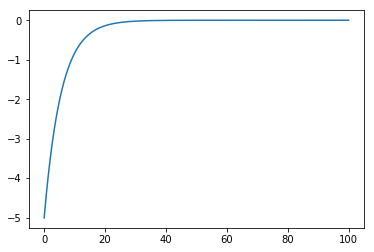

In [40]:
plt.figure()
plt.plot(t,np.real(u_modes_dmd_1[0]))
plt.show()

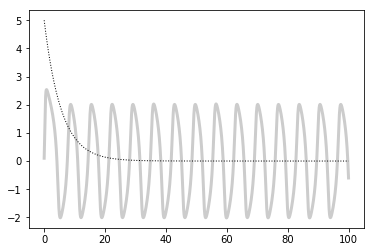

In [41]:
X_dmd_1 = Phi_dmd_1*u_modes_dmd_1

plt.figure()
plt.plot(t,x[0],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_1[0]),c='0',ls=':',lw=1)
plt.show()

### 5. Use the time-delay coordinates to build a Koopman/DMD model for forecasting.

Do DMD on $ X_1 $ and $ X_2 $ to find $ A $ so that $ \lVert X_2 - AX_1 \rVert_F $ is minimized where $ X_1 $ is like the time delay matrix, and $ X_2 $ is the time delay matrix forward in time one step.

In [42]:
X1_1 = H_1[:,:-1]
X2_1 = H_1[:,1:]

r_1 = 10
Lambda_1, Phi_1 = get_dmd_modes(X1_1,X2_1,r_1)

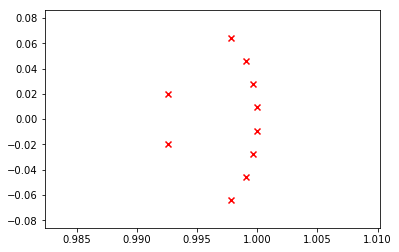

In [43]:
plt.figure()
#plt.plot(np.cos(np.linspace(0,2*np.pi,100)),np.sin(np.linspace(0,2*np.pi,100)))
plt.scatter(np.real(Lambda_1),np.imag(Lambda_1),marker='x',c='r')
#plt.axes().set_aspect('equal')
plt.show()

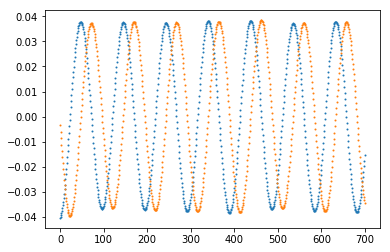

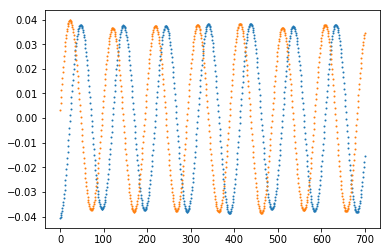

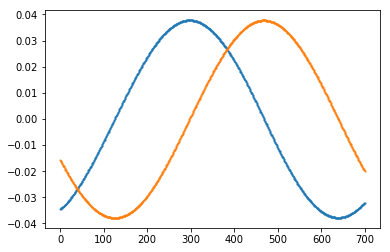

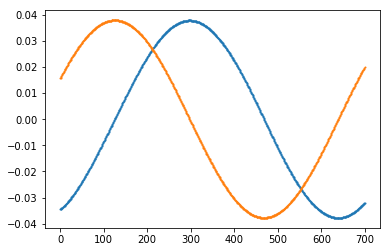

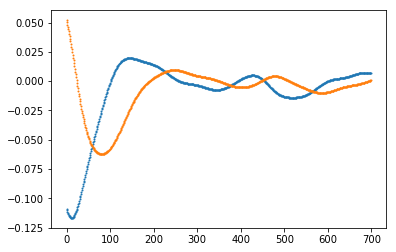

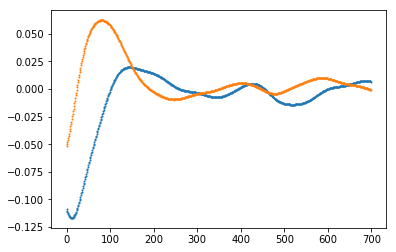

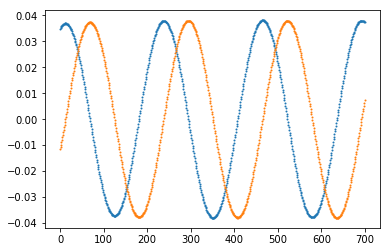

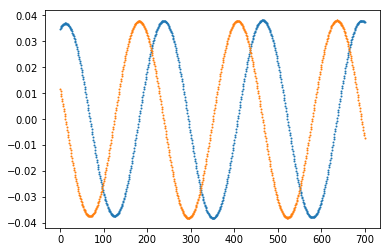

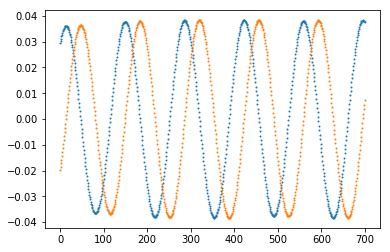

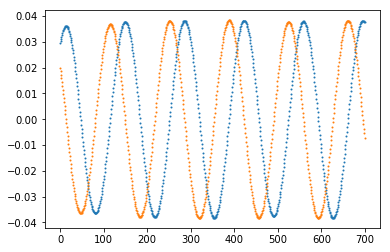

In [44]:
for j in range(r):
    plt.figure()
    plt.plot(np.arange(J_1),np.real(Phi_1[:,j]),marker='.',ms='2',ls='None')
    plt.plot(np.arange(J_1),np.imag(Phi_1[:,j]),marker='.',ms='2',ls='None')
    plt.show()

In [45]:
u_modes_1 = get_mode_time_evolution(Lambda_1, Phi_1, X1_1[:,0],t)

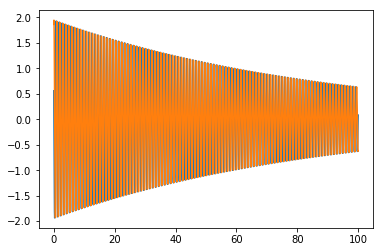

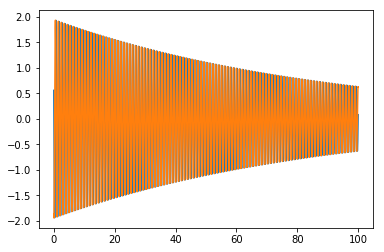

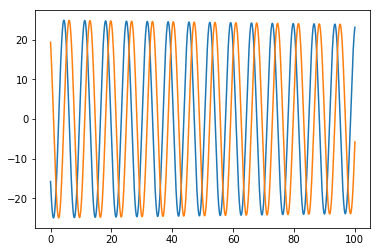

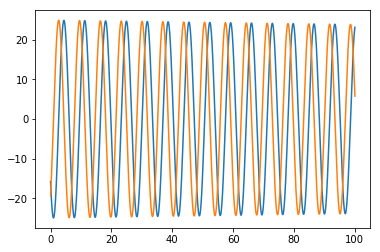

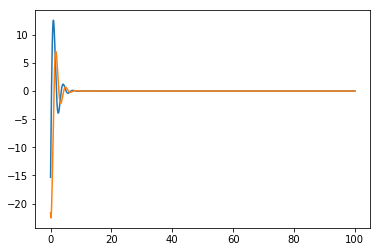

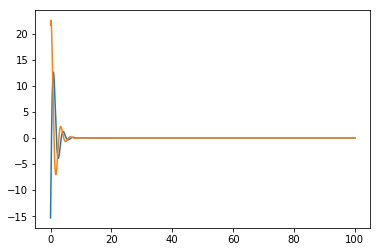

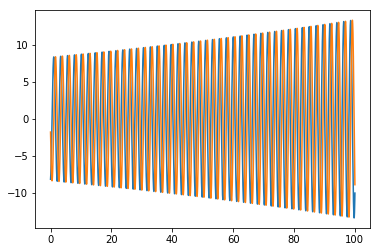

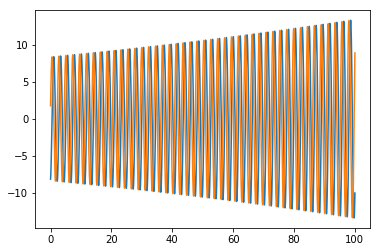

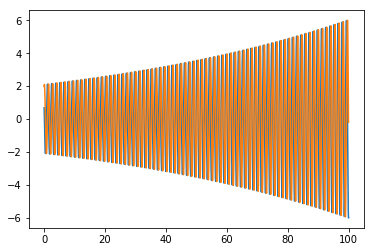

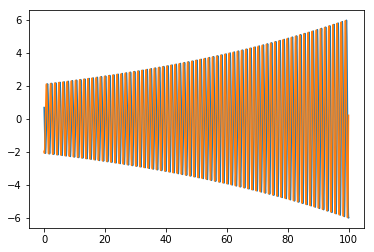

In [46]:
for j in range(r):
    plt.figure()
    plt.plot(t,np.real(u_modes_1[j]))
    plt.plot(t,np.imag(u_modes_1[j]))
    plt.show()

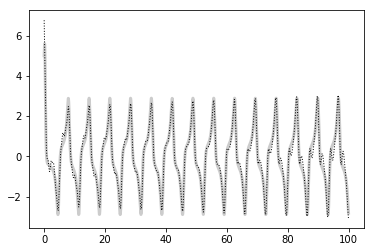

In [47]:
X_dmd_1 = Phi_1@u_modes_1

plt.figure()
plt.plot(t,x[1],c='.8',linewidth=3)
plt.plot(t,np.real(X_dmd_1[0]),c='k',ls=':',lw=1)
plt.show()

